# Baseline Experiments

In this notebook we run the baseline experiments from Section 2.5 of the paper, where we run the All Singletons, Giant and mean Doc length Predictions. For this we also create Kernel Density Estimation plot of both the settings over all ements, as well as the settings over the averages of all the sets in the dataet. We also perform some basic EDA on the clustering dataset and show the mean number of clusters and mean number of elements in the clusters. The main goal of this part of the research is to highlight the differences of the ELM and BCUBED metrics, and provide an exploration of when these differences are largest, and thus in what kind of tasks the usage of ELM might be preferred over BCUBED.

## Index

1. [Dataset Exploration](#ref1)
2. [Non-Learned Baselines](#ref2)
   - 2.1 [Only Singletons](#ref3)
   - 2.2 [Giant Cluster](#ref4)
   - 2.3 [Mean Document Length](#ref5)
   - 2.4 [Large Grid Figure](#ref6)


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from typing import List
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Latex

# Get the functions from the local utils file
%run ../utils/metricutils.py

## Loading in the clustering dataset.
- For all the non-learned baselines we use the entire dataset as these methods do not employ any learning, and as such we don't have to worry about overfitting on the test set. Moreover it will give us an even more complete picture of the differences between BCUBED and ELM.

In [2]:
# The data is presented as a json file where each key is a unique identifier, and each value is a binary array where 1s specify
# cluster boundaries. For example {'stream_1': [1, 0, 0, 0, 1]}


# We load in both the original train and test queries and we combine them in to final datasets we run the experiments on 
train_set = {key: np.array(val) for key, val in read_json('../data/train/train.json').items()}
test_set = {key: np.array(val) for key, val in read_json('../data/test/test.json').items()}

dataset = {**train_set, **test_set}

<a id="ref1"/>

## Data Exploration on the dataset

To get an idea of the characteristics of the dataset we are working with we will perform some very simply data exploration, reporting numbers on the number of elements in the total dataset, as well as the number of clusters and the percentage of singleton clusters.

In [3]:
# To obtain the sizes of the clusters we use the 'bin_to_length_list' function from the 
# 'metricutils' file, which converts a binary array containing the clusters to an array that contains
# the size of each cluster. 

# get the length of this list to know the number of clusters in each gold standard set of elements
number_of_clusters = sum([len(bin_to_length_list(item)) for item in dataset.values()])

# Get the sizes of all the individual clusters in the entire testset.
cluster_sizes = pd.Series([item for stream in dataset.values() for item in bin_to_length_list(stream)])

# Get all binary page representations so that we can get the total number of pages in the dataset.
all_pages = [item for stream in dataset.values() for item in stream]

# Print the statistics
print("The dataset consists of %d streams" % len(dataset))
print("The dataset has a total number of %d clusters" % number_of_clusters)
print("The dataset consists of a total of %d pages" % len(all_pages))

The dataset consists of 110 streams
The dataset has a total number of 24180 clusters
The dataset consists of a total of 89491 pages


Next we will print the mean and median number of cluster sizes.

In [4]:
print("Mean cluster size is %d" % cluster_sizes.mean())
print("Median cluster size is %d" % cluster_sizes.median())

Mean cluster size is 3
Median cluster size is 2


To get an even deeper understanding about the distribution of the dataset, we now plot the KDE Distrubtion of the cluster sizes for the entire testset.

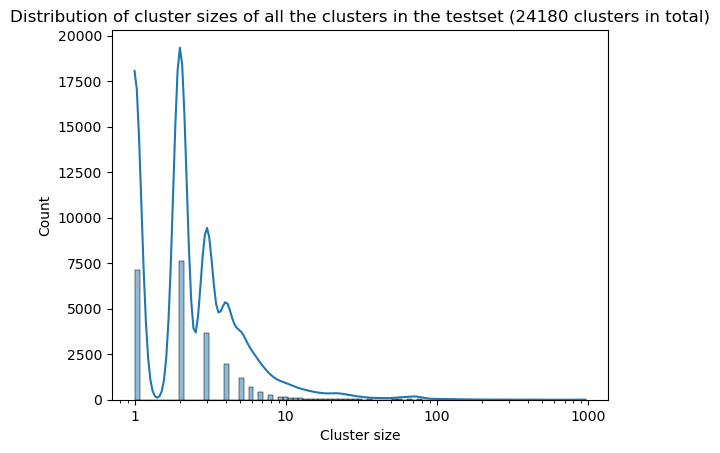

In [5]:
import matplotlib.ticker
fig, ax = plt.subplots(1, 1)

cluster_sizes_plot = sns.histplot(data = cluster_sizes, log_scale=[True, False], kde=True, axes=ax)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

# Set the x axi label and the title of the plot
plt.xlabel("Cluster size")
plt.savefig('dataset_clsuter_sizes.png')
plt.title("Distribution of cluster sizes of all the clusters in the testset (24180 clusters in total)")
plt.show()


Finally, We also calculate the average percentage of singleton clusters in each stream, as this is important for later, when I want to show that the biggest impact of the ELM metric is on these small clusters.

In [6]:
percentage_of_singletons = []

for stream in dataset.values():
    list_of_clusters = bin_to_length_list(stream)
    percentage_of_singletons.append((list_of_clusters==1).sum() / len(list_of_clusters))

print("On average, each stream contains %d percent singleton clusters "% (pd.Series(percentage_of_singletons).mean()*100))

On average, each stream contains 33 percent singleton clusters 


<a id="ref2" />

## Non-Learned Baselines

In [7]:
# TODO: See if I can add the standard deviation column as string to the mean column.
def create_score_dataframe(dataframe_bcubed, dataframe_elm):
    
    # First we do this for the BCUBED values
    bcubed_vals = dataframe_bcubed.describe().iloc[1:3, :].round(2)
    bcubed_vals.iloc[0, :] =  '$\mu=$' + bcubed_vals.iloc[0].astype(str) + ", $\sigma$=" + bcubed_vals.iloc[1, :].astype(str)
    bcubed_vals.drop(bcubed_vals.tail(1).index, inplace=True)
    bcubed_vals.rename(index={'mean': "BCUBED"}, inplace=True)
    
    # Next we do this for the ELM values
    elm_vals = dataframe_elm.describe().iloc[1:3, :].round(2)
    elm_vals.iloc[0, :] =  '$\mu=$' + elm_vals.iloc[0].astype(str) + ", $\sigma$=" + elm_vals.iloc[1, :].astype(str)
    elm_vals.drop(elm_vals.tail(1).index, inplace=True)
    elm_vals.rename(index={'mean': "ELM"}, inplace=True)
    
    display_df = pd.concat([bcubed_vals, elm_vals], axis=0)
    
    display(display_df)
    
    
    

In order to evaluate the difference in behaviour of the BCUBED and ELM metrics, we want to study its effect on different types of systems. For the first set of experiments, we will compare the two metrics on non-learned baseline systems, namely systems that predict only singleton clusters, only one large cluster containing all elements, and a system that makes each cluster the average size of the cluster size in the partition. 

In [8]:
# Set up both the singleton and one large cluster predictions
only_singleton_predictions = {key: np.ones_like(val) for key, val in dataset.items()}

# For the giant cluster predictions, we still need the first item to be a one
giant_cluster_predictions = {key: np.concatenate([[1], np.zeros(len(val)-1)]) for key, val in dataset.items()}

Let's make some functions that let us nicely plot these different plots of BCUBED and ELM side by side in a 3 by 1 plot.

In [9]:
# We create this function so that we can get the predictions of all the streams.
# Because we also want to be able to use this to make plots of the individual plots
# we also use the original stream names. We can then use Pandas groupign to obtain the predictions
# for the streams.
def get_bcubed_and_elm_scores(gold_standard_dict, prediction_dict):
    # Here we calculate the scores for BCUBED and ELM reporting precision, recall and f1
    bcubed_scores = []
    elm_scores = []

    # Save the scores of each element seperately
    for gold_clustering in gold_standard_dict.keys():
        bcubed_score = bcubed(gold_standard_dict[gold_clustering], prediction_dict[gold_clustering])
        elm_score = elm(gold_standard_dict[gold_clustering], prediction_dict[gold_clustering])
        
        # give names to the elements in the stream so that we can later use groupby to get the stream means
        # for the tables
        bcubed_score['name'] = gold_clustering
        elm_score['name'] = gold_clustering
        
        bcubed_scores.append(bcubed_score)
        elm_scores.append(elm_score)
        
    bcubed_df = pd.concat(bcubed_scores)
    elm_df = pd.concat(elm_scores)
    
    return bcubed_df, elm_df


In [10]:
# We can drop the size column, this doesn't make sense for aggregated values.
def get_mean_stream_predictions(score_dataframe):
    mean_scores = score_dataframe.groupby('name').mean()
    return mean_scores.drop('size', axis=1)

In [11]:
def plot_kde_with_mean_and_std(dataseries, axis, legend_label: str, color: str, 
                              fontsize: int = 10, first=True, mean_label_location: float = 2.0,
                              std_label_location: float = 0.6, title="", linestyle=None):
    # We first create the basic kde plot, to which we can then add the information about mean and 
    # standard deviation
    basic_kdeplot = sns.kdeplot(data=dataseries, ax=axis, cut=0, clip=[0, 1], label=legend_label,
                             fill=False, color=color, ls=linestyle)

    # Get the information about the mean and standard deviation for the lines
    line_idx = 0 if first else 1
    xline = basic_kdeplot.lines[line_idx].get_xdata()
    yline = basic_kdeplot.lines[line_idx].get_ydata()
    data_mean = dataseries.mean()
    data_std = dataseries.std()

    height = np.interp(data_mean, xline, yline)
    # Plot the dotted mean line
    basic_kdeplot.vlines(data_mean, 0, height, color=color, ls=':')
    
    # Use the annotate function from matplotlib to create a double headed arrow showing the standard deviation
    
    axis.annotate("", (max(0,data_mean-data_std), std_label_location-0.2), (data_mean+data_std, std_label_location-0.2), arrowprops=dict(arrowstyle='<->'))
    
    # Create labels for the actual values of the mean and standard deviation of the KDE plot
    axis.text(max(0.1, data_mean-data_std), std_label_location, s="$\sigma=%.2f$" % data_std, fontsize=fontsize)
    axis.text(max(0.1, data_mean), mean_label_location, s="$\mu=%.2f$" % data_mean, fontsize=fontsize)
    axis.set_yticklabels([])
    axis.set_xlim(0.0, 1.0)
    axis.set_ylabel("")
    
    # Showing standard deviation as a shaded plot a bit tricky we have to calculate which values fall between it and
    # only select those.
    plot_values = pd.Series(xline).between(data_mean-data_std, data_mean+data_std)
    # select only the rang of values that fall between 1 times the standard deviation on both sides
    # of the mean
    min_idx, max_idx = plot_values.idxmax(), plot_values[::-1].idxmax()
    basic_kdeplot.fill_between(xline[min_idx:max_idx], 0, yline[min_idx:max_idx], facecolor=color, alpha=0.2)
    # Return the plot for further customization options later
    return basic_kdeplot


<a id="ref3" />

In [12]:
def plot_p_r_f1_difference_kdes(dataframe_bcubed, dataframe_elm, mean_label_locations: List[float] = [2.5, 3.6],
                                std_label_locations: List[float] = [0.6, 1.0], list_of_axes: list=[], title=""):
    
    assert sorted(list(dataframe_bcubed.columns)) == sorted(list(dataframe_elm.columns))
    
    # TODO: return the plots so that I can later put them in the 3 by 3 plot
    if not len(list_of_axes):
        _, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))
    else:
        axes=list_of_axes
        
    for i, col_name in enumerate(dataframe_bcubed.columns):
        col_data_bcubed = dataframe_bcubed[col_name]
        col_data_elm = dataframe_elm[col_name]
        if col_data_elm.nunique() == 1:
            # Both will just indicate 1, so just plot a boxplot with both set at 1
            axes[i].bar(0.40, 1, 0.1, label='BCUBED', color='crimson', alpha=0.5)
            axes[i].bar(0.50, 1, 0.1, label="ELM", color='blue', alpha=0.5)
            axes[i].set_xlim(left=0, right=1)
            axes[i].set_xlabel(col_name)   
            axes[i].set_yticklabels([])
            
        else:
            plot_kde_with_mean_and_std(col_data_bcubed, axis=axes[i], legend_label="BCUBED", color="crimson", mean_label_location=mean_label_locations[0],
                                      std_label_location=std_label_locations[0], linestyle="-")
            plot_kde_with_mean_and_std(col_data_elm, axis=axes[i], legend_label="ELM", color="blue", first=False, std_label_location=std_label_locations[1],
                                      mean_label_location=mean_label_locations[1], linestyle='-.')
    plt.suptitle(title)

### Singleton prediction

Here we run the All singletons model against the gold standard, where we get both the raw scores for all elements, as well as the aggregated mean scores.

In [13]:
singleton_bcubed_predictions, singleton_elm_predictions = get_bcubed_and_elm_scores(dataset, only_singleton_predictions)
singleton_bcubed_streams, singleton_elm_streams = get_mean_stream_predictions(singleton_bcubed_predictions), get_mean_stream_predictions(singleton_elm_predictions)

#### Exploring the behaviour of the singleton predictions through KDE plots

We will explore the behaviour of both the metrics on the singleton cluster predictions by plotting several KDE pltos. We will start by plotting the KDE over all the elements, and in the second set of KDE plots we will aggregate these values over the streams to get a more general view on the differences in behaviour between ELM and BCUBED.

In [14]:
KDE_data_bcubed_all_elements = singleton_bcubed_predictions[['P', 'R', 'F1']]
KDE_data_elm_all_elements = singleton_elm_predictions[['P', 'R', 'F1']]

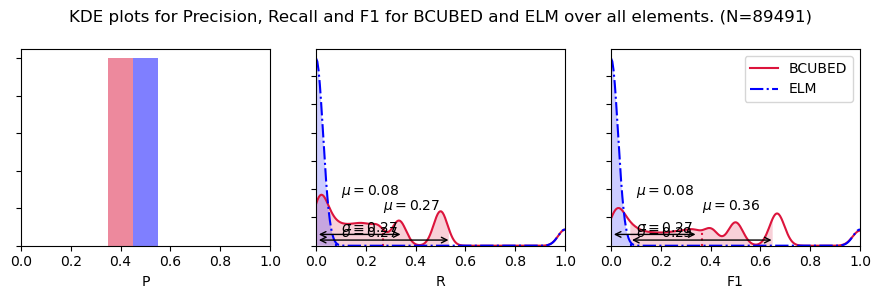

In [15]:
plot_p_r_f1_difference_kdes(KDE_data_bcubed_all_elements, KDE_data_elm_all_elements)
plt.suptitle("KDE plots for Precision, Recall and F1 for BCUBED and ELM over all elements. (N=89491)")
plt.legend()
plt.tight_layout()
plt.show()


To provide a bit more of a 'smoothed' view, we will repeat the above plot, but then over all **streams** instead of over all elements. This means aggregating all the values for the individual elements to the values for streams, we do this by taking the average over P, R and F1 over all elements in a stream.

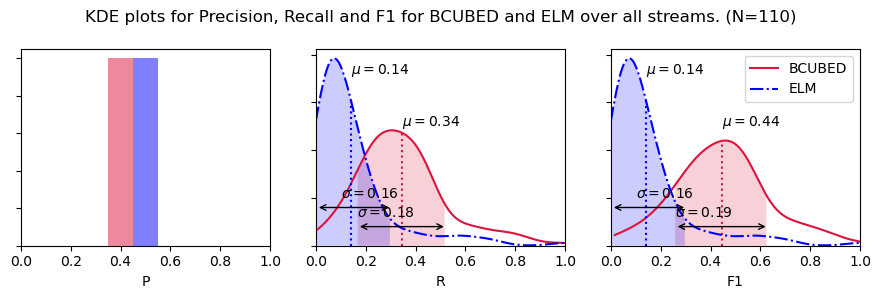

In [16]:
plot_p_r_f1_difference_kdes(singleton_bcubed_streams, singleton_elm_streams )
plt.suptitle("KDE plots for Precision, Recall and F1 for BCUBED and ELM over all streams. (N=110)")
plt.legend()
plt.tight_layout()
plt.show()


### Binning the element differences

Although the element KDE plots are already quite insightful, the information is still a bit much to all show in the paper. For this reason, we will bin the differences between ELM and BCUBED ELM over all elements and put this in a table to indicate where the largest differences between the metrics lies.

In [17]:
def bin_bcubed_kde_differences(bcubed_dataframe, elm_dataframe):
    differences = bcubed_dataframe[['P', 'R', 'F1']] - elm_dataframe[['P', 'R', 'F1']]
    f1_differences = differences['F1']
    difference_bins = (0.0, 0.1, 0.2, 0.5, 0.75, 1.0)
    binned_values = pd.cut(f1_differences, right=False, bins=difference_bins, labels=['0', '0.1 < 0.2', '0.2 < 0.5',
                                                                     '0.5 < 0.75', '0.75 < 1.0'])
    
    diff_df = pd.DataFrame({'F1': f1_differences, 'bin': binned_values})

    difference_table = diff_df['bin'].value_counts(normalize=True)
    
    display(difference_table.sort_index())
    
    
bin_bcubed_kde_differences(KDE_data_bcubed_all_elements,
                           KDE_data_elm_all_elements)



0             0.345051
0.1 < 0.2     0.107854
0.2 < 0.5     0.252629
0.5 < 0.75    0.294465
0.75 < 1.0    0.000000
Name: bin, dtype: float64

<a id="ref4" />

## Giant Cluster predictions

In this section we repeat the experiments and plots above, but in this case we use the predictions that put all the elements in a gold standard sample into one giant cluster.

In [18]:
giant_bcubed_predictions, giant_elm_predictions = get_bcubed_and_elm_scores(dataset, giant_cluster_predictions)
giant_bcubed_streams, giant_elm_streams = get_mean_stream_predictions(giant_bcubed_predictions), get_mean_stream_predictions(giant_elm_predictions)

#### Giant Cluster KDE plots

Again, let's first do the plots with all the elements, followed by the plot where the averages over all streams are taken.

In [19]:
KDE_data_bcubed_all_elements_giant = giant_bcubed_predictions[['P', 'R', 'F1']]
KDE_data_elm_all_elements_giant = giant_elm_predictions[['P', 'R', 'F1']]

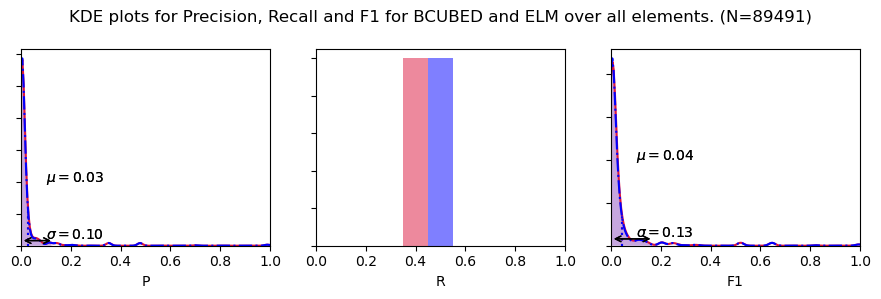

In [20]:
plot_p_r_f1_difference_kdes(KDE_data_bcubed_all_elements_giant, KDE_data_elm_all_elements_giant, mean_label_locations=[10, 10], std_label_locations=[1, 1])
plt.suptitle("KDE plots for Precision, Recall and F1 for BCUBED and ELM over all elements. (N=89491)")
plt.tight_layout()
plt.show()


As with the singleton predictions, let's bin these differences so that we get an even better picture of how big these differences really are.

In [21]:
# Differences are much smaller here than when compared to the singleton streams
bin_bcubed_kde_differences(KDE_data_bcubed_all_elements_giant,
                           KDE_data_elm_all_elements_giant)

0             0.999497
0.1 < 0.2     0.000402
0.2 < 0.5     0.000101
0.5 < 0.75    0.000000
0.75 < 1.0    0.000000
Name: bin, dtype: float64

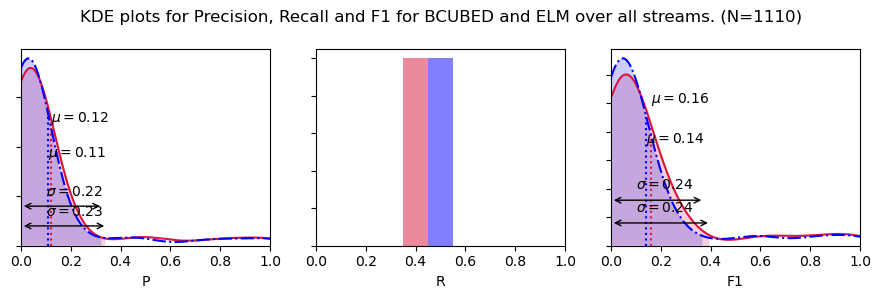

In [22]:
plot_p_r_f1_difference_kdes(giant_bcubed_streams, giant_elm_streams, mean_label_locations=[2.5, 1.8])
plt.suptitle("KDE plots for Precision, Recall and F1 for BCUBED and ELM over all streams. (N=1110)")
plt.tight_layout()
plt.show()


<a id="ref5" />

## Mean Document Length baselines

To provide a meaningful non-extreme baseline we also present a baseline where we predict clusterings by taking the mean document length of a stream, and using this to make all documents the same length. We calculate this baseline by calculating the mean document length of every stream, and making all documents in a partition this size.

In [23]:
# write a function to do the mean document length prediction
def mean_doc_length_per_stream_prediction(gold_standard_dict: dict):
    output_dict = {}
    for key, val in gold_standard_dict.items():
        mean_doc_length = int(bin_to_length_list(val).mean())
        prediction_stream = np.zeros_like(val)
        prediction_stream[0] = 1
        
        # now we use the modulu operator to set the pages that start new documents to 1
        prediction_stream[np.arange(len(val)) % mean_doc_length == 0] = 1
        output_dict[key] = prediction_stream
    return output_dict
        


In [24]:
# create the dictionary with the predictions
mean_doc_length_predictions = mean_doc_length_per_stream_prediction(dataset)

In [25]:
mean_doc_bcubed_predictions_all_elements, mean_doc_elm_predictions_all_elements = get_bcubed_and_elm_scores(dataset, mean_doc_length_predictions)
mean_doc_bcubed_streams, mean_doc_elm_streams = get_mean_stream_predictions(mean_doc_bcubed_predictions_all_elements), get_mean_stream_predictions(mean_doc_elm_predictions_all_elements)

As with the two previous baselines, we plot both the KDE plots over all elements as well ass the KDE plots average over all of the streams.

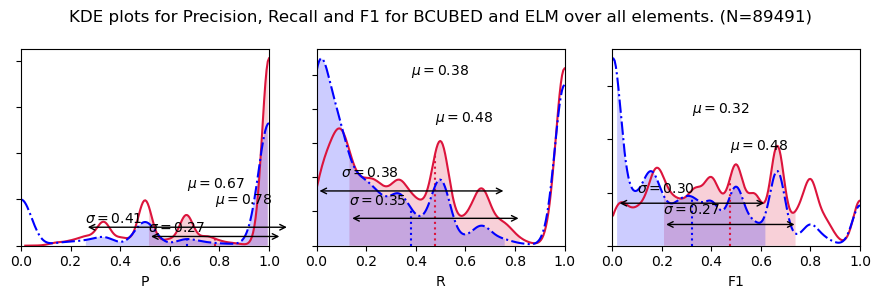

In [26]:
plot_p_r_f1_difference_kdes(mean_doc_bcubed_predictions_all_elements[['P', 'R', 'F1']], mean_doc_elm_predictions_all_elements[['P', 'R', 'F1']], mean_label_locations=[1.8, 2.5])
plt.suptitle("KDE plots for Precision, Recall and F1 for BCUBED and ELM over all elements. (N=89491)")
plt.tight_layout()
plt.show()


In [27]:
# Differences still exist but less extreme than with the singleton predictions
bin_bcubed_kde_differences(mean_doc_bcubed_predictions_all_elements,
                           mean_doc_elm_predictions_all_elements)

0             0.522377
0.1 < 0.2     0.270575
0.2 < 0.5     0.107374
0.5 < 0.75    0.099675
0.75 < 1.0    0.000000
Name: bin, dtype: float64

Now we will plot the same plot as above, but now over all streams, where the average scores over elements are taken.

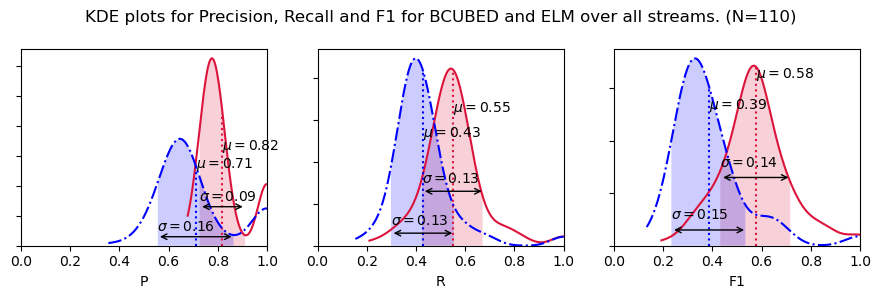

In [28]:
plot_p_r_f1_difference_kdes(mean_doc_bcubed_streams[['P', 'R', 'F1']], mean_doc_elm_streams[['P', 'R', 'F1']], mean_label_locations=[3.2, 2.6],
                           std_label_locations=[1.5, 0.5])
plt.suptitle("KDE plots for Precision, Recall and F1 for BCUBED and ELM over all streams. (N=110)")
plt.tight_layout()
plt.show()


<a id="ref6" />

### Large 3 by 3 plots of all baselines

Here we gather the 3 KDE summary plots that we collected earlier and display them in a 3 by 3 grid. For this we will take the more 'smoothed' versions of the KDE plots where we calculated the scores for the baselines using the aggregated values of elements over streams.

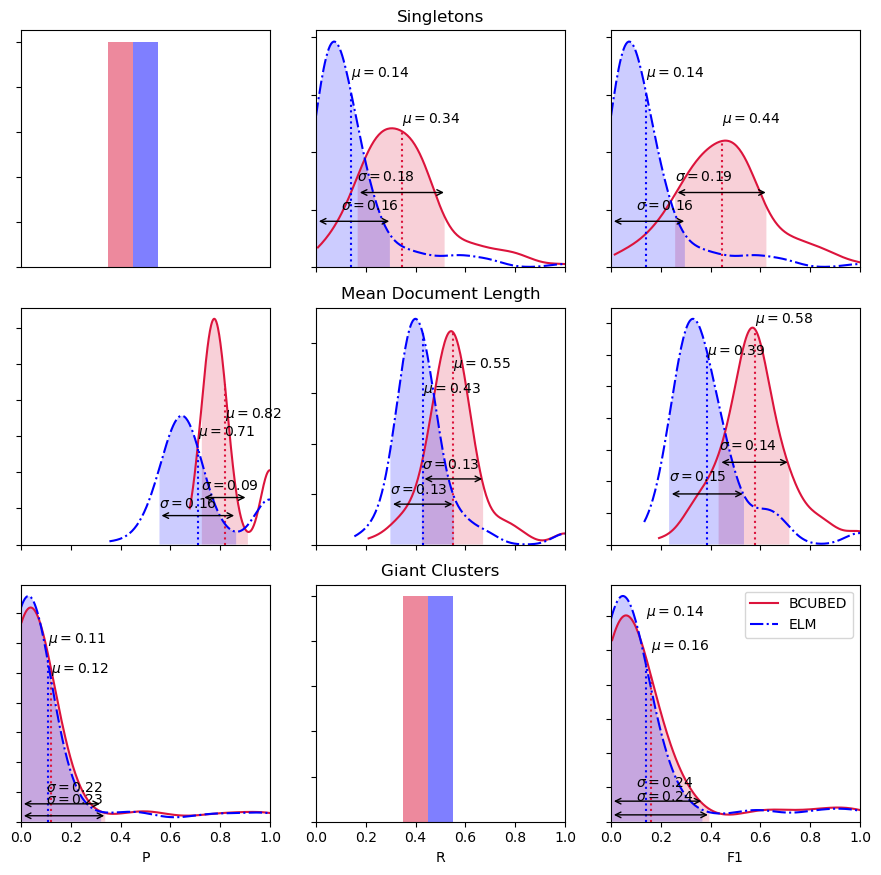

In [29]:
# The plots are quite OK, but I really have to tweak the positions of the 
# labels a bit, and also see how I can update the last rows so that it looks
# nicer, as the differences are very small here, probably just show one set of arrows.
fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, figsize=(9, 9))

plot_data = [[singleton_bcubed_streams, singleton_elm_streams],
             [mean_doc_bcubed_streams[['P', 'R', 'F1']], mean_doc_elm_streams[['P', 'R', 'F1']]],
             [giant_bcubed_streams, giant_elm_streams]]

# let's just do all the plots sequentially, bit cumbersome, but gives us more control

label_positions = [[[2.5, 3.3], [1.5, 1]], [[3.5, 3], [1.5, 1]], [[2.5, 3], [0.3, 0.5]]]
titles= ["Singletons", "Mean Document Length", "Giant Clusters"]

for i, row in enumerate(plot_data):
        plot_p_r_f1_difference_kdes(row[0], row[1], list_of_axes=axes[i, :], mean_label_locations=label_positions[i][0], std_label_locations=label_positions[i][1])
        axes[i, 1].set_title(titles[i])
        
axes[0][0].get_xaxis().set_visible(False)
        
plt.legend()
plt.tight_layout()
plt.savefig('../images/Fig4.png')
plt.show()